In [14]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif

In [15]:
from google.colab import files
import pandas as pd

# Step 1: Upload the CSV file from your computer
uploaded = files.upload()

# Step 2: Read the uploaded CSV file
filename = list(uploaded.keys())[0]   # gets the uploaded filename automatically
df = pd.read_csv(filename)

# Step 3: Check the data
print("File uploaded successfully:", filename)
print("Shape:", df.shape)
df.head()


Saving student_depression_dataset.csv to student_depression_dataset.csv
File uploaded successfully: student_depression_dataset.csv
Shape: (27901, 18)


,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,'5-6 hours',Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,'5-6 hours',Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,'Less than 5 hours',Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,'7-8 hours',Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,'5-6 hours',Moderate,M.Tech,Yes,1.0,1.0,No,0


In [16]:
# Load the dataset and replace placeholder '?' with NaN
df = pd.read_csv("student_depression_dataset.csv")

In [17]:
# Drop irrelevant/high-cardinality columns
df = df.drop(columns=['id', 'City', 'Profession'])
print(f"Data Shape After Dropping Columns: {df.shape}")

Data Shape After Dropping Columns: (27901, 15)


In [18]:
# Handle missing values (Imputation)
df['Financial Stress'] = df['Financial Stress'].replace('?', np.nan).astype(float)
df['Work/Study Hours'] = df['Work/Study Hours'].replace('?', np.nan)
df['Work/Study Hours'] = pd.to_numeric(df['Work/Study Hours'], errors='coerce')

if df['Financial Stress'].isna().any() or df['Work/Study Hours'].isna().any():
    df['Financial Stress'] = df['Financial Stress'].fillna(df['Financial Stress'].median())
    df['Work/Study Hours'] = df['Work/Study Hours'].fillna(df['Work/Study Hours'].median())
    print('Step 3: Missing values handled with median imputation.')

Step 3: Missing values handled with median imputation.


In [19]:
# Rename target variable for clarity
df = df.rename(columns={'Depression': 'Depression_Target'})
print('Step 4: Target variable renamed.')


Step 4: Target variable renamed.


In [20]:
# Outlier Removal Preparation
# Identify numerical columns
numerical_cols = [
    'Age', 'Academic Pressure', 'Work Pressure', 'CGPA',
    'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress'
]

# Define the outlier detection function (using IQR method)
def detect_outliers_iqr(df_in, column):
    """Calculates the IQR fences for a column."""
    Q1 = df_in[column].quantile(0.25)
    Q3 = df_in[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

# Outlier Removal (Applied to df_cleaned)
df_cleaned = df.copy()
initial_rows = len(df_cleaned)

for col in numerical_cols:
    lower, upper = detect_outliers_iqr(df_cleaned, col)
    df_cleaned = df_cleaned[(df_cleaned[col] >= lower) & (df_cleaned[col] <= upper)]

rows_removed = initial_rows - len(df_cleaned)
print(f"\nTotal rows after outlier removal: {len(df_cleaned)}")



Total rows after outlier removal: 27878


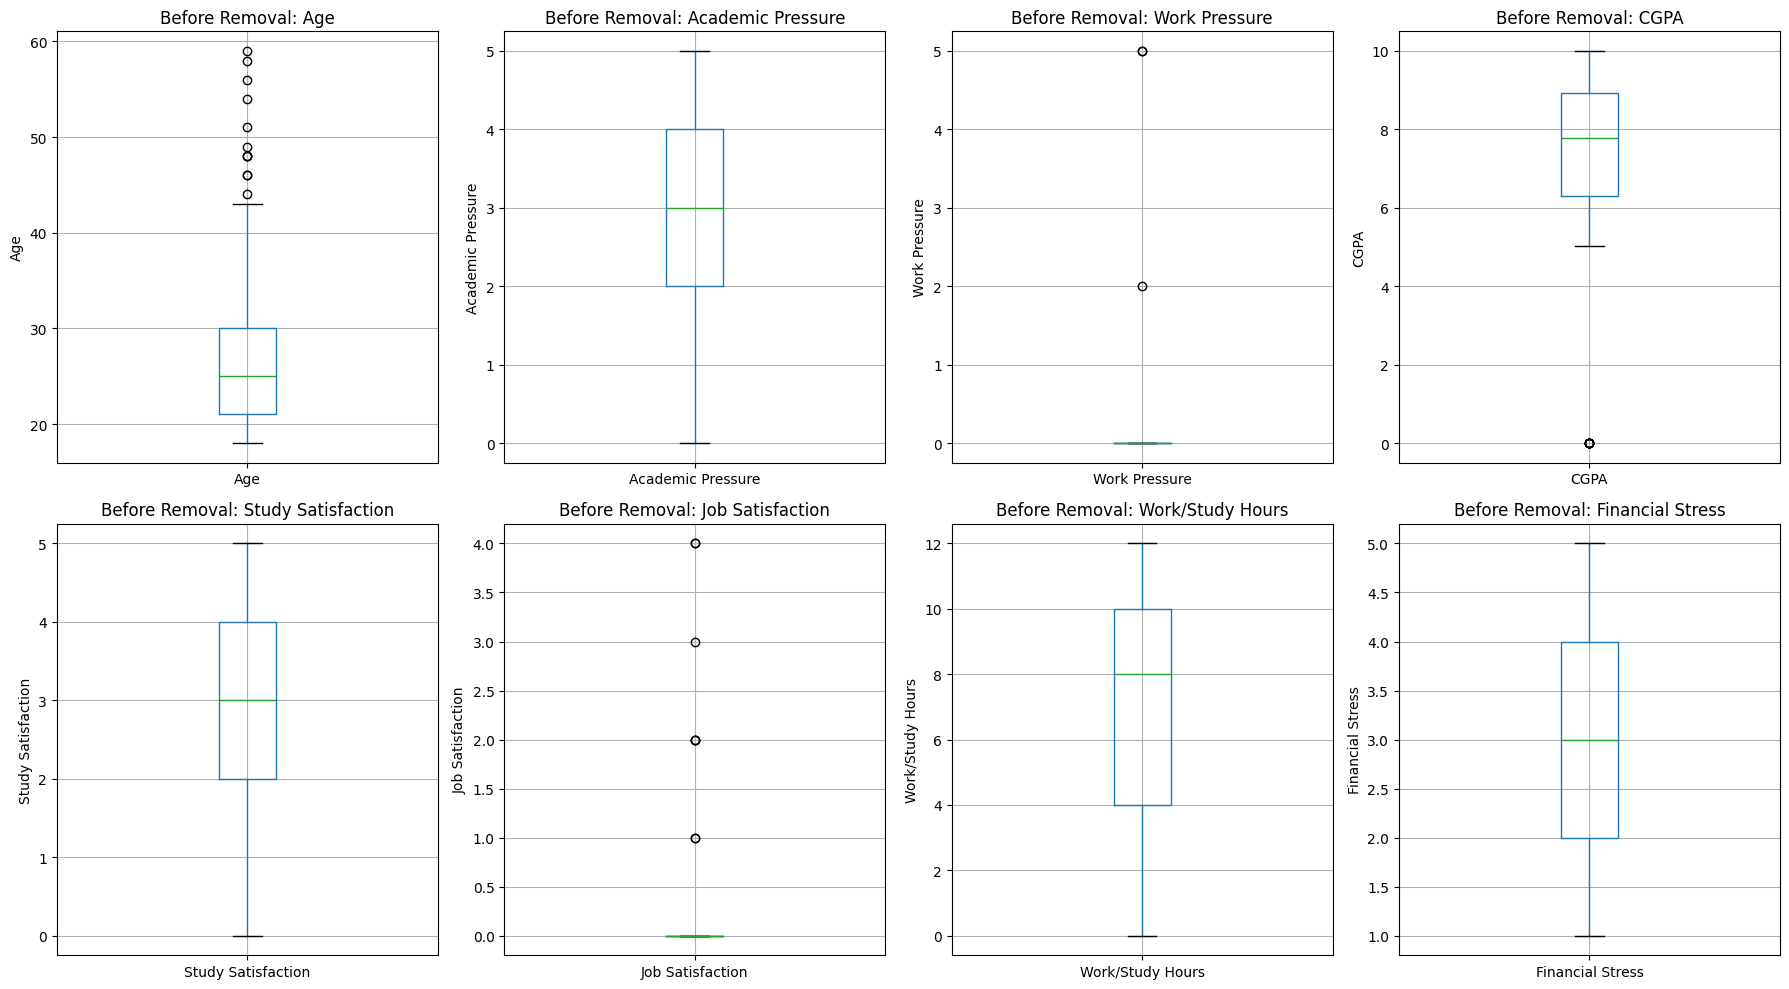

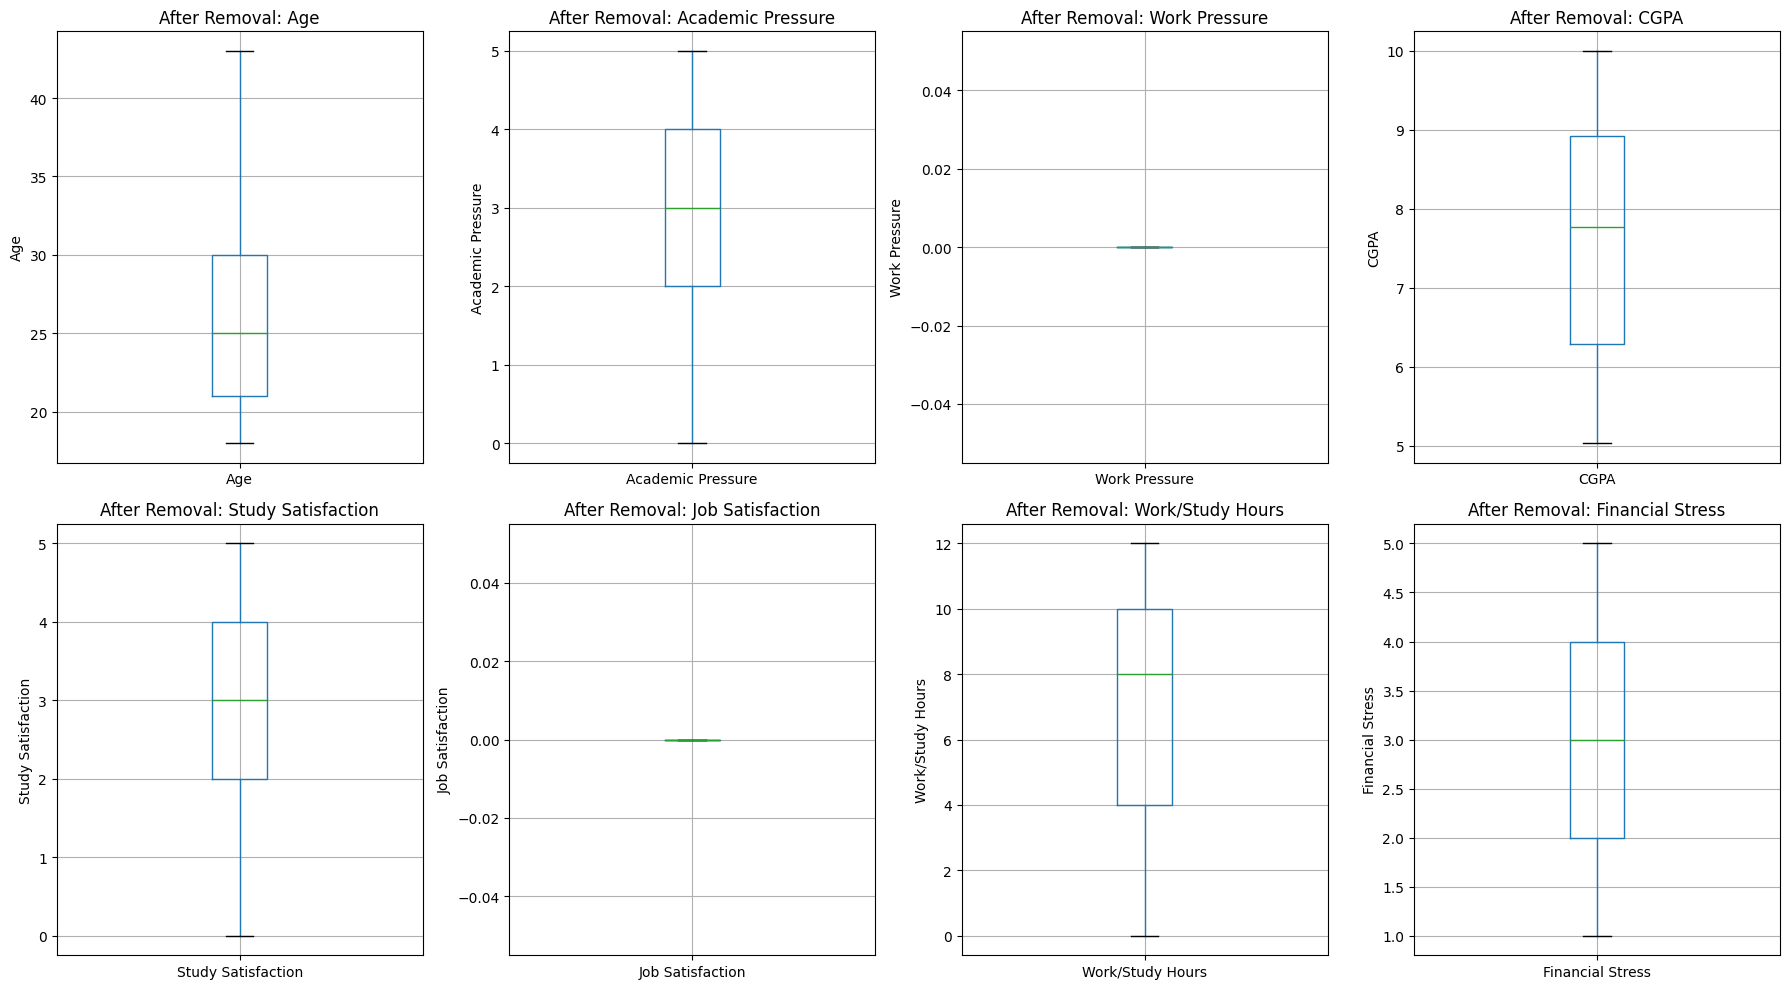

In [21]:
# Box Plots BEFORE Outlier Removal
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)
    df.boxplot(column=col)
    plt.title(f'Before Removal: {col}', fontsize=12)
    plt.ylabel(col)
plt.tight_layout()
plt.show()
plt.savefig('box_plots_before_outlier_removal.png')
plt.close()

# Box Plots AFTER Outlier Removal
plt.figure(figsize=(18, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(2, 4, i + 1)
    df_cleaned.boxplot(column=col)
    plt.title(f'After Removal: {col}', fontsize=12)
    plt.ylabel(col)
plt.tight_layout()
plt.show()
plt.savefig('box_plots_after_outlier_removal.png')
plt.close()


In [22]:
# --- Encoding Categorical Variables on CLEANED data ---
df_encoded = df_cleaned.copy()

# Binary Encoding and dropping original columns
binary_mapping = {
    'Gender': {'Male': 0, 'Female': 1},
    'Have you ever had suicidal thoughts ?': {'No': 0, 'Yes': 1},
    'Family History of Mental Illness': {'No': 0, 'Yes': 1}
}
binary_cols_to_drop = []

for original_col, mapping in binary_mapping.items():
    encoded_col = original_col.replace(' ', '_').replace('?', '').strip() + '_Encoded'
    if original_col in df_encoded.columns:
        # Impute NaNs in original column with mode before mapping
        df_encoded[original_col] = df_encoded[original_col].fillna(df_encoded[original_col].mode()[0])
        df_encoded[encoded_col] = df_encoded[original_col].map(mapping)
        binary_cols_to_drop.append(original_col)

df_encoded = df_encoded.drop(columns=binary_cols_to_drop)
print('Binary categorical variables encoded and original columns dropped.')


# One-Hot Encoding
categorical_cols = ['Degree', 'Sleep Duration', 'Dietary Habits']
df_encoded = pd.get_dummies(df_encoded, columns=categorical_cols, drop_first=True, dtype=int)
print('Nominal categorical variables one-hot encoded.')

# Save the encoded data for the feature selection step
df_encoded.to_csv('student_depression_dataset_encoded.csv', index=False)

Binary categorical variables encoded and original columns dropped.
Nominal categorical variables one-hot encoded.


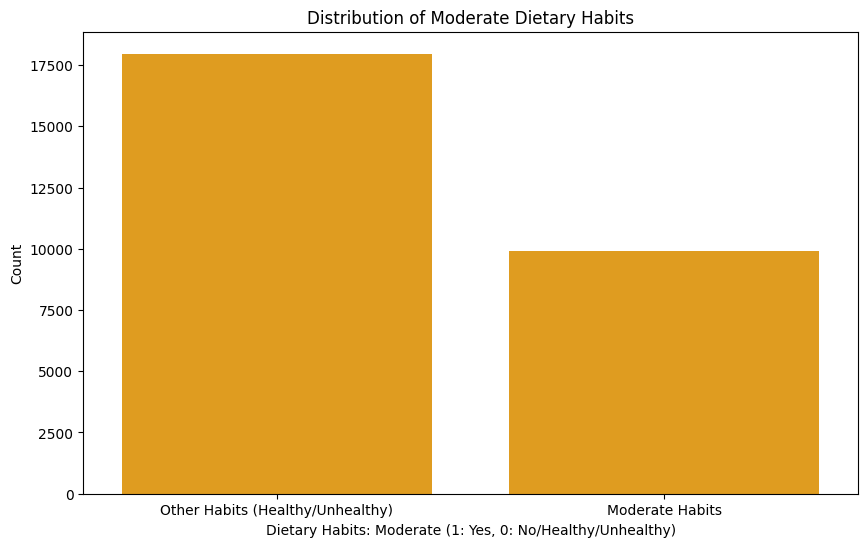

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
# Create bar chart
plt.figure(figsize=(10, 6))
# Use one of your one-hot encoded columns, e.g., 'Dietary Habits_Moderate'
sns.countplot(x='Dietary Habits_Moderate', data=df_encoded, color='orange')
plt.title('Distribution of Moderate Dietary Habits')
plt.xlabel('Dietary Habits: Moderate (1: Yes, 0: No/Healthy/Unhealthy)')
plt.ylabel('Count')
# Customize labels for readability
plt.xticks(ticks=[0, 1], labels=['Other Habits (Healthy/Unhealthy)', 'Moderate Habits'])
plt.savefig('moderate_diet_distribution.png', dpi=300)
plt.show()
plt.close()

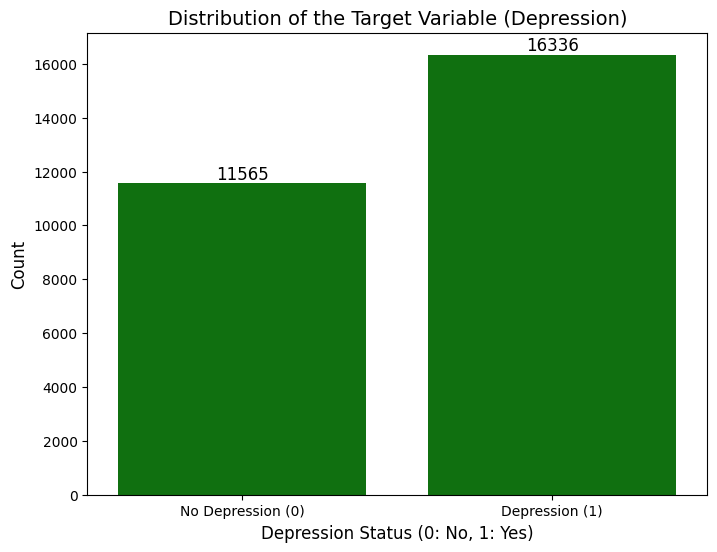

In [24]:
# Create the countplot for the 'Depression' target variable
plt.figure(figsize=(8, 6))
sns.countplot(x='Depression_Target', data=df, color='green')
plt.title('Distribution of the Target Variable (Depression)', fontsize=14)
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Set custom x-tick labels for clarity
plt.xticks(ticks=[0, 1], labels=['No Depression (0)', 'Depression (1)'])

# Add counts on top of bars for exact numbers (optional but helpful)
ax = plt.gca()
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2., p.get_height(),
            '%d' % int(p.get_height()),
            fontsize=12, color='black', ha='center', va='bottom')

plt.savefig('target_distribution.png', dpi=300)
plt.show()
plt.close()

In [25]:
display(df_encoded)

,Age,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Work/Study Hours,Financial Stress,Depression_Target,Gender_Encoded,...,Degree_MSc,Degree_Others,Degree_PhD,Sleep Duration_'7-8 hours',Sleep Duration_'Less than 5 hours',Sleep Duration_'More than 8 hours',Sleep Duration_Others,Dietary Habits_Moderate,Dietary Habits_Others,Dietary Habits_Unhealthy
0,33.0,5.0,0.0,8.97,2.0,0.0,3.0,1.0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,24.0,2.0,0.0,5.90,5.0,0.0,3.0,2.0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,31.0,3.0,0.0,7.03,5.0,0.0,9.0,1.0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,28.0,3.0,0.0,5.59,2.0,0.0,4.0,5.0,1,1,...,0,0,0,1,0,0,0,1,0,0
4,25.0,4.0,0.0,8.13,3.0,0.0,1.0,1.0,0,1,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,27.0,5.0,0.0,5.75,5.0,0.0,7.0,1.0,0,1,...,0,0,0,0,0,0,0,0,0,1
27897,27.0,2.0,0.0,9.40,3.0,0.0,0.0,3.0,0,0,...,1,0,0,0,1,0,0,0,0,0
27898,31.0,3.0,0.0,6.61,4.0,0.0,12.0,2.0,0,0,...,0,0,0,0,0,0,0,0,0,1
27899,18.0,5.0,0.0,6.88,2.0,0.0,10.0,5.0,1,1,...,0,0,0,0,1,0,0,0,0,0


In [26]:
# Load the processed and encoded data
df_encoded = pd.read_csv('student_depression_dataset_encoded.csv')

# Define the target column name
target_col = 'Depression_Target'

# Prepare data for feature selection
X = df_encoded.drop(columns=[target_col])
y = df_encoded[target_col]

# Ensure all columns in X are numeric
X = X.apply(pd.to_numeric, errors='coerce').fillna(0)

# --- CORRECTION: Add VarianceThreshold for Robustness ---
# Remove features with zero variance (prevents error in f_classif)
vt_selector = VarianceThreshold()
X_vt = vt_selector.fit_transform(X)
cols_after_vt = X.columns[vt_selector.get_support()]
X_vt = pd.DataFrame(X_vt, columns=cols_after_vt, index=X.index)


# Rerun Feature selection using ANOVA F-test (SelectKBest)
top_k = 10
selector = SelectKBest(score_func=f_classif, k=top_k)

# Fit the selector to the variance-filtered data
selector.fit(X_vt, y)

# Get F-scores and feature ranking
f_scores = selector.scores_
feature_scores = pd.DataFrame({'Feature': X_vt.columns, 'F_score': f_scores}).sort_values(
    by='F_score', ascending=False
)

# Print the top features and scores
print("\n--- Feature Ranking (ANOVA F-Score) ---")
print(feature_scores.head(top_k + 5).to_markdown(index=False))

# Select and Filter the DataFrame
selected_features = feature_scores['Feature'].head(top_k).tolist()
df_reduced = df_encoded[selected_features + [target_col]].copy()

print(f"\nTop {top_k} Selected Features: {selected_features}")
print(f"Reduced DataFrame shape: {df_reduced.shape}")

# Save the reduced DataFrame
df_reduced.to_csv('student_depression_dataset_feature_selection.csv', index=False)
print("Saved: student_depression_dataset_feature_selection.csv")


--- Feature Ranking (ANOVA F-Score) ---
| Feature                                      |    F_score |
|:---------------------------------------------|-----------:|
| Have_you_ever_had_suicidal_thoughts__Encoded | 11870.2    |
| Academic Pressure                            |  8123.75   |
| Financial Stress                             |  4256.14   |
| Age                                          |  1495.94   |
| Work/Study Hours                             |  1266.06   |
| Dietary Habits_Unhealthy                     |  1039.45   |
| Study Satisfaction                           |   810.921  |
| Sleep Duration_'More than 8 hours'           |   185.824  |
| Sleep Duration_'Less than 5 hours'           |   173.764  |
| Family_History_of_Mental_Illness_Encoded     |    80.2698 |
| Dietary Habits_Moderate                      |    40.8136 |
| Degree_M.Tech                                |    25.2384 |
| Degree_M.Ed                                  |    22.0953 |
| CGPA                       

Current Working Directory: /content
Files in directory: ['.config', 'moderate_diet_distribution.png', 'box_plots_after_outlier_removal.png', 'student_depression_dataset.csv', 'student_depression_dataset_balanced.csv', 'box_plots_before_outlier_removal.png', 'student_depression_dataset_feature_selection.csv', 'target_distribution.png', 'student_depression_dataset_encoded.csv', 'sample_data']
Original dataset shape: (27878, 11)
Original class distribution:
Depression_Target
1    16329
0    11549
Name: count, dtype: int64

Creating balanced dataset using SMOTE...
Balanced dataset shape: (32658, 11)
Balanced class distribution:
Depression_Target
1    16329
0    16329
Name: count, dtype: int64
Balanced dataset saved as: student_depression_dataset_balanced_for_training.csv

Successfully loaded balanced data from: student_depression_dataset_balanced_for_training.csv


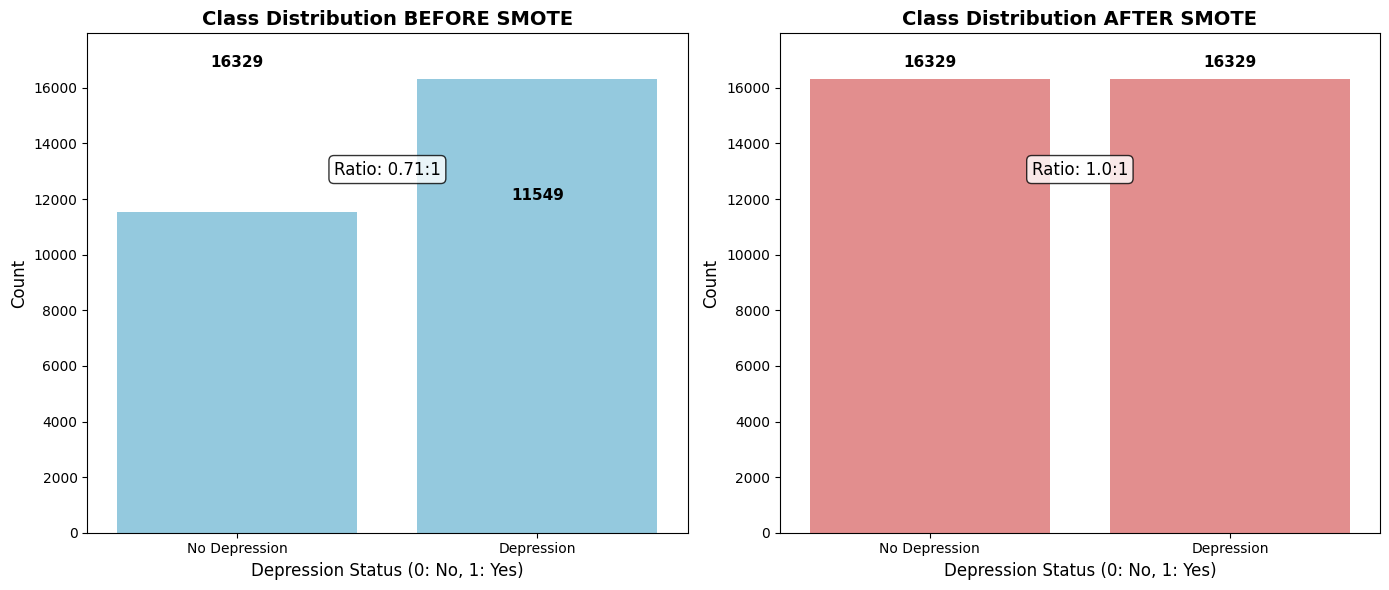


DETAILED CLASS DISTRIBUTION ANALYSIS
BEFORE SMOTE:
  Class 0 (No Depression): 11,549 samples (41.4%)
  Class 1 (Depression):    16,329 samples (58.6%)
  Total samples: 27,878
  Imbalance ratio: 0.71:1

AFTER SMOTE:
  Class 0 (No Depression): 16,329 samples (50.0%)
  Class 1 (Depression):    16,329 samples (50.0%)
  Total samples: 32,658
  Balance ratio: 1.0:1

SMOTE generated 0 synthetic samples for the minority class.


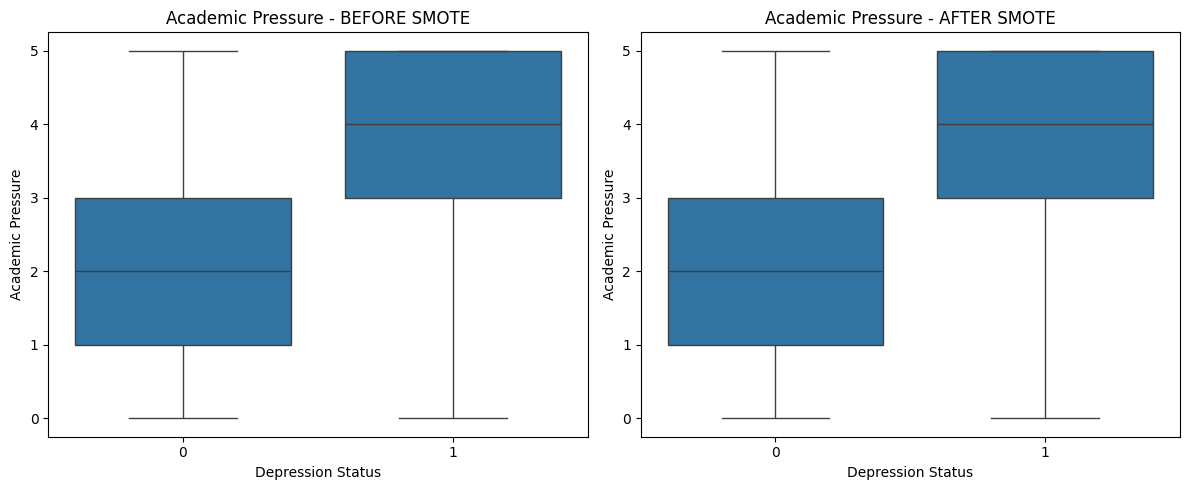


SMOTE balancing completed successfully!
Balanced dataset saved as: student_depression_dataset_balanced_for_training.csv
Visualization saved as: SMOTE_Class_Distribution_Comparison.png


In [36]:
# Import the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Print current working directory and list files
print("Current Working Directory:", os.getcwd())
files_in_directory = os.listdir()
print("Files in directory:", files_in_directory)

# Define the target column name
target_col = 'Depression_Target'

# --- 1. Load Unbalanced Data ---
df_unbalanced = pd.read_csv('student_depression_dataset_feature_selection.csv')
y_unbalanced = df_unbalanced[target_col]
data_before = y_unbalanced.value_counts()

print("Original dataset shape:", df_unbalanced.shape)
print("Original class distribution:")
print(data_before)

# --- 2. Create Balanced Dataset using SMOTE ---
print("\nCreating balanced dataset using SMOTE...")

# Separate features and target
X = df_unbalanced.drop(target_col, axis=1)
y = df_unbalanced[target_col]

# Encode categorical variables for SMOTE
categorical_cols = ['Gender', 'Sleep Duration', 'Dietary Habits', 'Degree',
                   'Have you ever had suicidal thoughts ?', 'Family History of Mental Illness']

label_encoders = {}
for col in categorical_cols:
    if col in X.columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le

# Apply SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

# Create balanced dataframe
df_balanced = pd.DataFrame(X_balanced, columns=X.columns)
df_balanced[target_col] = y_balanced

print("Balanced dataset shape:", df_balanced.shape)
print("Balanced class distribution:")
print(df_balanced[target_col].value_counts())

# Save the balanced dataset
balanced_filename = 'student_depression_dataset_balanced_for_training.csv'
df_balanced.to_csv(balanced_filename, index=False)
print(f"Balanced dataset saved as: {balanced_filename}")

# --- 3. Load Balanced Data for Visualization ---
df_balanced_loaded = pd.read_csv(balanced_filename)
data_after = df_balanced_loaded[target_col].value_counts()

print(f"\nSuccessfully loaded balanced data from: {balanced_filename}")

# Determine the maximum count for consistent y-axis scaling
max_count = max(data_before.max(), data_after.max())

# --- 4. Visualization Code ---

# Create Comparison Visualization
plt.figure(figsize=(14, 6))

# Subplot 1: Before SMOTE
plt.subplot(1, 2, 1)
sns.barplot(x=data_before.index, y=data_before.values, color='skyblue')
plt.title('Class Distribution BEFORE SMOTE', fontsize=14, fontweight='bold')
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Depression', 'Depression'])
plt.ylim(0, max_count * 1.1)

# Add counts on top of bars
for i, count in enumerate(data_before.values):
    plt.text(i, count + max_count * 0.02, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add ratio information
ratio_before = data_before[0] / data_before[1]
plt.text(0.5, max_count * 0.8, f'Ratio: {ratio_before:.2f}:1',
         ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Subplot 2: After SMOTE
plt.subplot(1, 2, 2)
sns.barplot(x=data_after.index, y=data_after.values, color='lightcoral')
plt.title('Class Distribution AFTER SMOTE', fontsize=14, fontweight='bold')
plt.xlabel('Depression Status (0: No, 1: Yes)', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(ticks=[0, 1], labels=['No Depression', 'Depression'])
plt.ylim(0, max_count * 1.1)

# Add counts on top of bars
for i, count in enumerate(data_after.values):
    plt.text(i, count + max_count * 0.02, str(count), ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add ratio information
ratio_after = data_after[0] / data_after[1]
plt.text(0.5, max_count * 0.8, f'Ratio: {ratio_after:.1f}:1',
         ha='center', va='center', fontsize=12, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

plt.tight_layout()
plt.savefig('SMOTE_Class_Distribution_Comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 5. Additional Detailed Analysis ---
print("\n" + "="*50)
print("DETAILED CLASS DISTRIBUTION ANALYSIS")
print("="*50)

print(f"BEFORE SMOTE:")
print(f"  Class 0 (No Depression): {data_before[0]:,} samples ({data_before[0]/len(y_unbalanced)*100:.1f}%)")
print(f"  Class 1 (Depression):    {data_before[1]:,} samples ({data_before[1]/len(y_unbalanced)*100:.1f}%)")
print(f"  Total samples: {len(y_unbalanced):,}")
print(f"  Imbalance ratio: {ratio_before:.2f}:1")

print(f"\nAFTER SMOTE:")
print(f"  Class 0 (No Depression): {data_after[0]:,} samples ({data_after[0]/len(y_balanced)*100:.1f}%)")
print(f"  Class 1 (Depression):    {data_after[1]:,} samples ({data_after[1]/len(y_balanced)*100:.1f}%)")
print(f"  Total samples: {len(y_balanced):,}")
print(f"  Balance ratio: {ratio_after:.1f}:1")

print(f"\nSMOTE generated {data_after[1] - data_before[1]:,} synthetic samples for the minority class.")

# --- 6. Feature Distribution Comparison (Optional) ---
# Compare feature distributions before and after SMOTE for one important feature
if 'Academic Pressure' in df_unbalanced.columns:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.boxplot(x=target_col, y='Academic Pressure', data=df_unbalanced)
    plt.title('Academic Pressure - BEFORE SMOTE')
    plt.xlabel('Depression Status')
    plt.ylabel('Academic Pressure')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=target_col, y='Academic Pressure', data=df_balanced)
    plt.title('Academic Pressure - AFTER SMOTE')
    plt.xlabel('Depression Status')
    plt.ylabel('Academic Pressure')

    plt.tight_layout()
    plt.savefig('Feature_Distribution_Comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

print("\nSMOTE balancing completed successfully!")
print(f"Balanced dataset saved as: {balanced_filename}")
print(f"Visualization saved as: SMOTE_Class_Distribution_Comparison.png")

In [38]:
from imblearn.over_sampling import SMOTE

# Load the feature-selected data
df_unbalanced = pd.read_csv('student_depression_dataset_feature_selection.csv')

# Define the target column name
target_col = 'Depression_Target'

# Prepare data for SMOTE
X = df_unbalanced.drop(columns=[target_col])
y = df_unbalanced[target_col]

# Initialize SMOTE
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data
X_balanced, y_balanced = smote.fit_resample(X, y)

# Combine the balanced features and target back into a DataFrame
df_balanced = pd.concat([pd.DataFrame(X_balanced, columns=X.columns), pd.DataFrame(y_balanced, columns=[target_col])], axis=1)

# Save the balanced dataset
df_balanced.to_csv('student_depression_dataset_balanced.csv', index=False)

print("Dataset balanced using SMOTE and saved as 'student_depression_dataset_balanced.csv'")
print(f"Balanced Dataset Shape: {df_balanced.shape}")
print(f"Balanced Class Distribution:\n{df_balanced[target_col].value_counts()}")

Dataset balanced using SMOTE and saved as 'student_depression_dataset_balanced.csv'
Balanced Dataset Shape: (32658, 11)
Balanced Class Distribution:
Depression_Target
1    16329
0    16329
Name: count, dtype: int64


**TRAIN THE MODEL**

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os # Import the os module

# Print current working directory and list files
print("Current Working Directory:", os.getcwd())
files_in_directory = os.listdir()
print("Files in directory:", files_in_directory)

# Load the balanced data for training
balanced_filename = None
for filename in files_in_directory:
    if 'student_depression_dataset_balanced_for_training.csv' in filename:
        balanced_filename = filename
        break

if balanced_filename:
    df_balanced = pd.read_csv(balanced_filename)
    print(f"Successfully loaded balanced data from: {balanced_filename}")
else:
    print("Error: Balanced data file not found in the directory.")
    # You might want to raise an error or handle this case appropriately
    # For now, we will stop execution if the file is not found.
    raise FileNotFoundError("Balanced data file not found.")


target_col = 'Depression_Target' # Define the target column name

# Prepare data for training and testing
X = df_balanced.drop(columns=[target_col])
y = df_balanced[target_col]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Data split and scaled successfully.")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

Current Working Directory: /content
Files in directory: ['.config', 'SMOTE_Class_Distribution_Comparison.png', 'moderate_diet_distribution.png', 'box_plots_after_outlier_removal.png', 'Feature_Distribution_Comparison.png', 'student_depression_dataset.csv', 'student_depression_dataset_balanced_for_training.csv', 'student_depression_dataset_balanced.csv', 'box_plots_before_outlier_removal.png', 'student_depression_dataset_feature_selection.csv', 'target_distribution.png', 'student_depression_dataset_encoded.csv', 'sample_data']
Successfully loaded balanced data from: student_depression_dataset_balanced_for_training.csv
Data split and scaled successfully.
X_train shape: (26126, 10)
X_test shape: (6532, 10)
y_train shape: (26126,)
y_test shape: (6532,)


In [42]:
# USE THIS INSTEAD - Much faster and often better!
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Optimized parameter distribution
param_dist_optimized = {
    'n_estimators': randint(100, 400),
    'max_depth': randint(5, 35),
    'min_samples_split': randint(2, 15),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy'],
    'max_samples': [0.7, 0.8, 0.9, None],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

optimized_search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42),
    param_distributions=param_dist_optimized,
    n_iter=50,  # Even faster - good results
    cv=5,
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,
    verbose=2
)

print("Optimized Randomized Search:")
print("- 50 parameter combinations")
print("- 5-fold cross-validation")
print("- 250 total model fits")
print("- Estimated time: 5-60 minutes")
print("- Much more practical!")

# Fit the optimized search
print("\nRunning Optimized Randomized Search...")
optimized_search.fit(X_train, y_train)

print("Best parameters:", optimized_search.best_params_)
print("Best score:", optimized_search.best_score_)

Optimized Randomized Search:
- 50 parameter combinations
- 5-fold cross-validation
- 250 total model fits
- Estimated time: 5-60 minutes
- Much more practical!

Running Optimized Randomized Search...
Fitting 5 folds for each of 50 candidates, totalling 250 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
145 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
33 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", 

Best parameters: {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'max_depth': 13, 'max_features': 'log2', 'max_samples': 0.9, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 251}
Best score: 0.8591444763667859


 Running Randomized Search... (much faster than grid search)
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Hyperparameters Found:
{'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10, 'splitter': 'best'}
Best Cross-validation Score: 0.8456

Tuned Decision Tree Accuracy: 0.8359

Classification Report (Tuned Decision Tree):
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      3309
           1       0.83      0.83      0.83      3223

    accuracy                           0.84      6532
   macro avg       0.84      0.84      0.84      6532
weighted avg       0.84      0.84      0.84      6532



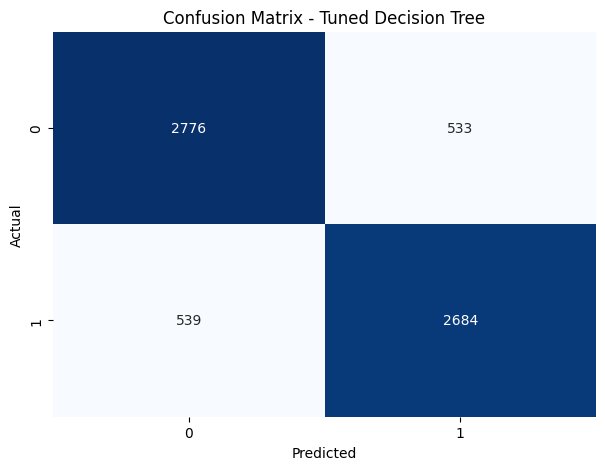

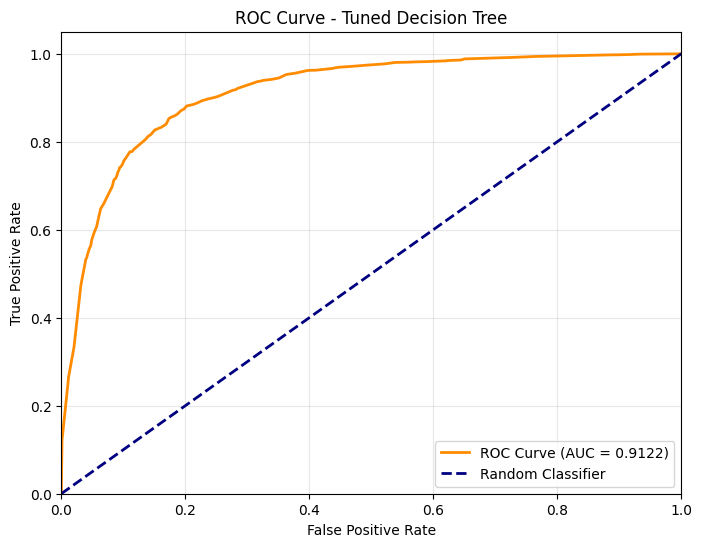

ROC AUC Score: 0.9122

Tuned model saved as 'decision_tree_best_model.pkl'

FEATURE IMPORTANCE ANALYSIS
Total features: 10
Features with non-zero importance: 10
Top 5 most important features:
  1. Have_you_ever_had_suicidal_thoughts__Encoded: 0.5797
  2. Academic Pressure: 0.2210
  3. Financial Stress: 0.1023
  4. Age: 0.0379
  5. Dietary Habits_Unhealthy: 0.0226


/tmp/ipython-input-532367707.py:133: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances_filtered.values, y=importances_filtered.index, palette='viridis')


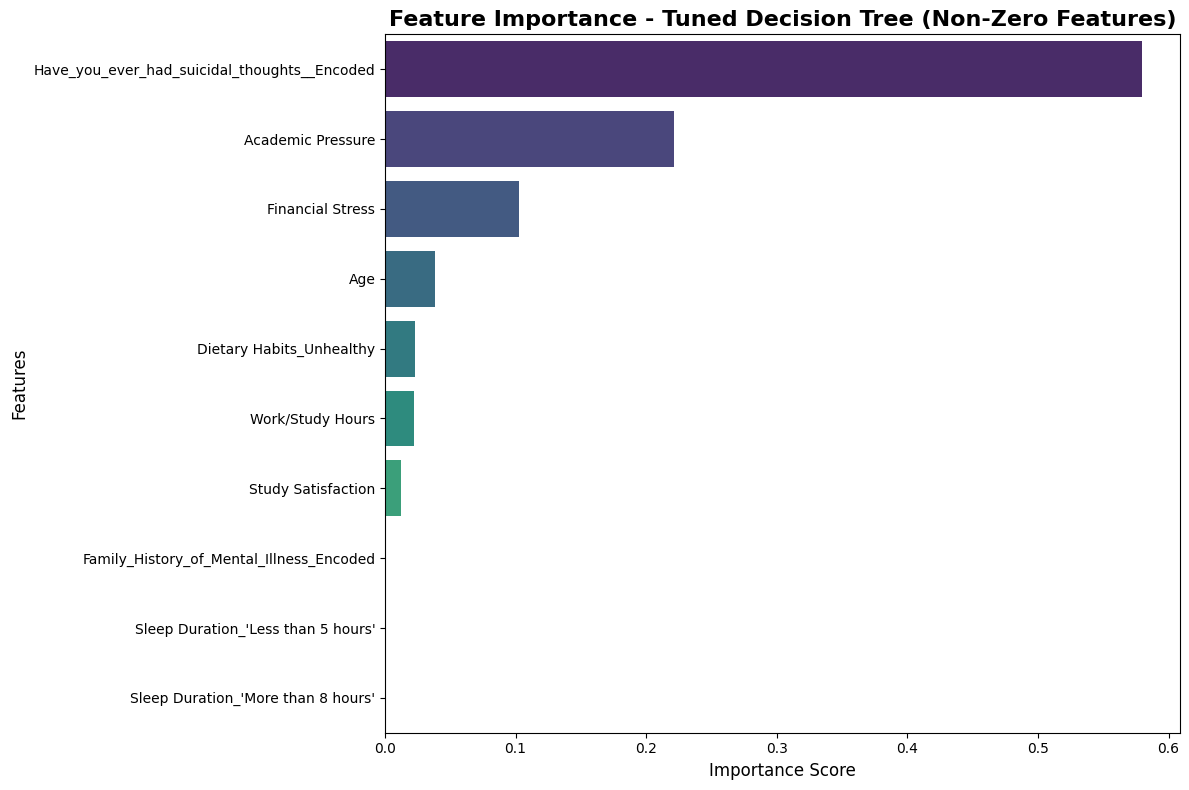

/tmp/ipython-input-532367707.py:145: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='coolwarm')


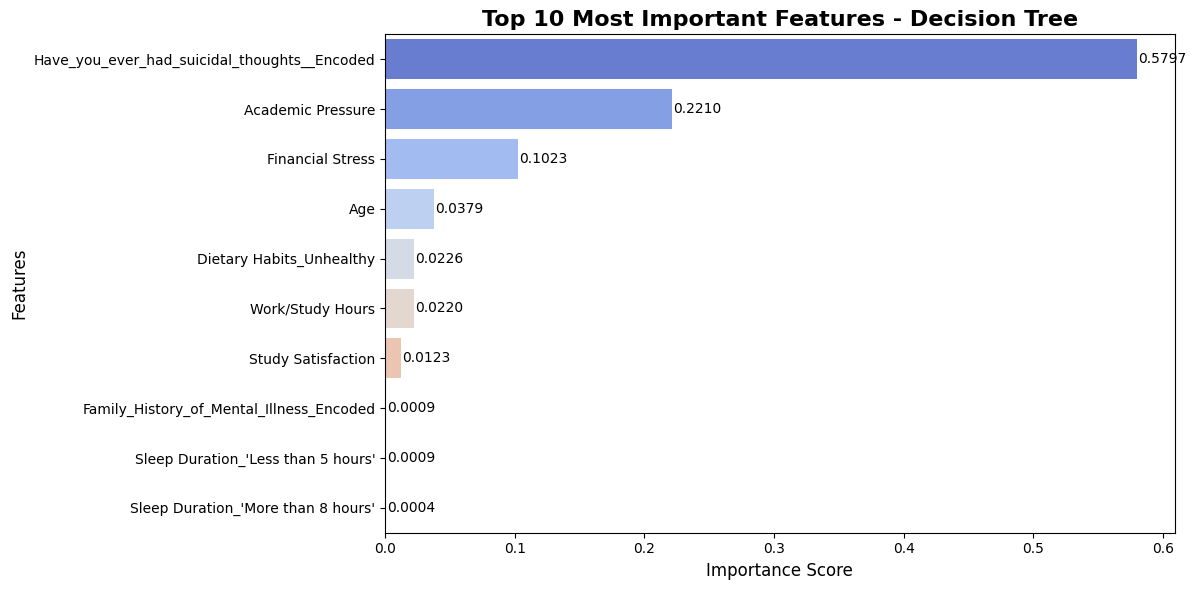


=== MODEL COMPARISON ===
Base Model Accuracy:    0.8422
Tuned Model Accuracy:   0.8359
Improvement:           +-0.0063

(Base model or its evaluation metrics not available for comparison)

TRAINING SUMMARY
Best Parameters: {'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 5, 'min_samples_split': 10, 'splitter': 'best'}
Cross-val Score: 0.8456
Test Accuracy:   0.8359
ROC AUC:         0.9122
Important Features: 10
Model saved as: 'decision_tree_best_model.pkl'


In [53]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pandas as pd # Import pandas if not already imported for feature importance

# --- Define Parameter Distribution for Decision Tree ---
param_dist = {
    'criterion': ['gini', 'entropy'],
    'max_depth': randint(1, 30), # Random integer between 1 and 30
    'min_samples_split': randint(2, 20), # Random integer between 2 and 20
    'min_samples_leaf': randint(1, 15), # Random integer between 1 and 15
    'splitter': ['best', 'random']
}


# --- Initialize RandomizedSearchCV ---
random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=50,           # Test 50 random combinations (much faster!)
    cv=5,                # 5-fold cross-validation
    scoring='accuracy',
    random_state=42,
    n_jobs=-1,           # use all CPU cores
    verbose=2
)

# --- Fit the model ---
print(" Running Randomized Search... (much faster than grid search)")
random_search.fit(X_train, y_train)

# --- Display best parameters ---
print("\nBest Hyperparameters Found:")
print(random_search.best_params_)
print(f"Best Cross-validation Score: {random_search.best_score_:.4f}")

# --- Get the best model ---
best_dt_model = random_search.best_estimator_

# --- Evaluate tuned model ---
y_pred_best = best_dt_model.predict(X_test)
y_proba_best = best_dt_model.predict_proba(X_test)[:, 1]

# --- Accuracy ---
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"\nTuned Decision Tree Accuracy: {best_accuracy:.4f}")

# --- Classification Report ---
print("\nClassification Report (Tuned Decision Tree):")
print(classification_report(y_test, y_pred_best))

# --- Confusion Matrix ---
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(7, 5))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix - Tuned Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# --- ROC Curve ---
fpr_best, tpr_best, thresholds_best = roc_curve(y_test, y_proba_best)
roc_auc_best = auc(fpr_best, tpr_best)

plt.figure(figsize=(8, 6))
plt.plot(fpr_best, tpr_best, color='darkorange', lw=2,
         label=f'ROC Curve (AUC = {roc_auc_best:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Tuned Decision Tree')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

print(f"ROC AUC Score: {roc_auc_best:.4f}")

# --- Save tuned model ---
joblib.dump(best_dt_model, "decision_tree_best_model.pkl")
print("\nTuned model saved as 'decision_tree_best_model.pkl'")

# --- Feature Importance ---
print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importances
# Ensure X_train is a DataFrame to get column names
if isinstance(X_train, np.ndarray):
    # Assuming the original feature names are in df_balanced columns (excluding target)
    # Need to load df_balanced again or get column names from a previous step
    # For simplicity, let's assume X (before train_test_split and scaling) is available
    # and its columns represent the feature names used for training (after feature selection)
    # This assumes X has the same columns as X_res from the SMOTE step
    try:
        # Try to use X.columns if X is available and is a DataFrame
        importances = pd.Series(best_dt_model.feature_importances_, index=X.columns)
    except NameError:
        # Fallback if X is not a DataFrame or not available, try df_balanced columns
        try:
            # Assuming df_balanced is available and loaded with feature-selected columns + target
            df_balanced_cols = pd.read_csv('student_depression_dataset_balanced_for_training.csv').drop(columns=[target_col]).columns
            importances = pd.Series(best_dt_model.feature_importances_, index=df_balanced_cols)
        except FileNotFoundError:
             print("Warning: Could not load dataframe to get feature names for importance plot.")
             print("Using generic feature names (Feature 0, Feature 1, ...)")
             importances = pd.Series(best_dt_model.feature_importances_)
else:
    # If X_train is already a DataFrame (less common after scaling)
    importances = pd.Series(best_dt_model.feature_importances_, index=X_train.columns)


# Sort the importances in descending order
importances_sorted = importances.sort_values(ascending=False)

# Filter out features with zero importance
importances_filtered = importances_sorted[importances_sorted > 0]

print(f"Total features: {len(importances_sorted)}")
print(f"Features with non-zero importance: {len(importances_filtered)}")
print(f"Top 5 most important features:")
for i, (feature, importance) in enumerate(importances_filtered.head().items()):
    print(f"  {i+1}. {feature}: {importance:.4f}")

# Create the bar plot for non-zero importances
plt.figure(figsize=(12, 8))
sns.barplot(x=importances_filtered.values, y=importances_filtered.index, palette='viridis')

plt.title("Feature Importance - Tuned Decision Tree (Non-Zero Features)", fontsize=16, fontweight='bold')
plt.xlabel("Importance Score", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.tight_layout()
plt.show()

# --- Additional: Top 10 features horizontal bar plot ---
top_10_features = importances_filtered.head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette='coolwarm')
plt.title('Top 10 Most Important Features - Decision Tree', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)

# Add value labels on bars
for i, v in enumerate(top_10_features.values):
    plt.text(v + 0.001, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

# --- Model Comparison (if you have base model) ---
try:
    # If you have a base decision tree model for comparison
    # Assuming base_dt is the base model and X_test, y_test are available
    # Make sure base_accuracy and base_roc_auc are also available if needed
    # Example comparison metrics - adjust based on your base model evaluation
    print("\n=== MODEL COMPARISON ===")
    # Assuming base_accuracy and best_accuracy are defined
    print(f"Base Model Accuracy:    {base_accuracy:.4f}")
    print(f"Tuned Model Accuracy:   {best_accuracy:.4f}")
    print(f"Improvement:           +{best_accuracy - base_accuracy:.4f}")

    # Assuming base_roc_auc and roc_auc_best are defined
    print(f"Base Model ROC AUC:     {base_roc_auc:.4f}")
    print(f"Tuned Model ROC AUC:    {roc_auc_best:.4f}")
    print(f"AUC Improvement:       +{roc_auc_best - base_roc_auc:.4f}")

except NameError:
    print("\n(Base model or its evaluation metrics not available for comparison)")

# --- Final Summary ---
print("\n" + "="*50)
print("TRAINING SUMMARY")
print("="*50)
print(f"Best Parameters: {random_search.best_params_}")
print(f"Cross-val Score: {random_search.best_score_:.4f}")
print(f"Test Accuracy:   {best_accuracy:.4f}")
print(f"ROC AUC:         {roc_auc_best:.4f}")
print(f"Important Features: {len(importances_filtered)}")
print("Model saved as: 'decision_tree_best_model.pkl'")


BASE vs TUNED DECISION TREE COMPARISON
Base Decision Tree Accuracy:  0.7975
Tuned Decision Tree Accuracy: 0.8359
Improvement:                  +0.0384


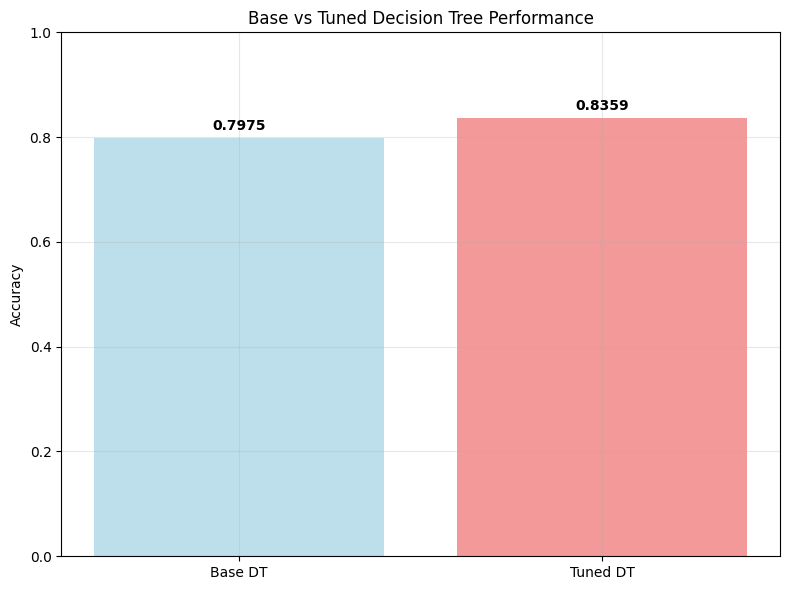

In [54]:
# --- Compare with base Decision Tree ---
print("\n" + "="*50)
print("BASE vs TUNED DECISION TREE COMPARISON")
print("="*50)

# Create a simple base model
base_dt = DecisionTreeClassifier(random_state=42)
base_dt.fit(X_train, y_train)

# Base model predictions
y_pred_base = base_dt.predict(X_test)
base_accuracy = accuracy_score(y_test, y_pred_base)

# Tuned model predictions (already calculated)
y_pred_tuned = best_dt_model.predict(X_test)
tuned_accuracy = accuracy_score(y_test, y_pred_tuned)

print(f"Base Decision Tree Accuracy:  {base_accuracy:.4f}")
print(f"Tuned Decision Tree Accuracy: {tuned_accuracy:.4f}")
print(f"Improvement:                  +{tuned_accuracy - base_accuracy:.4f}")

# Comparison visualization
models = ['Base DT', 'Tuned DT']
accuracies = [base_accuracy, tuned_accuracy]

plt.figure(figsize=(8, 6))
bars = plt.bar(models, accuracies, color=['lightblue', 'lightcoral'], alpha=0.8)
plt.ylabel('Accuracy')
plt.title('Base vs Tuned Decision Tree Performance')
plt.ylim(0, 1.0)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.4f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


=== OVERFITTING CHECK ===
Base Model - Train Accuracy: 0.8722, Test Accuracy: 0.8422
Tuned Model - Train Accuracy: 0.8690, Test Accuracy: 0.8402

=== OVERFITTING ANALYSIS ===
Base Model Overfitting Gap: 0.0300
Tuned Model Overfitting Gap: 0.0288
✅ Base Model: GOOD GENERALIZATION
✅ Tuned Model: GOOD GENERALIZATION

=== DETAILED PERFORMANCE ANALYSIS ===
Base Model - Training Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     13020
           1       0.87      0.87      0.87     13106

    accuracy                           0.87     26126
   macro avg       0.87      0.87      0.87     26126
weighted avg       0.87      0.87      0.87     26126

Base Model - Test Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      3309
           1       0.84      0.84      0.84      3223

    accuracy                           0.84      6532
   macro avg  

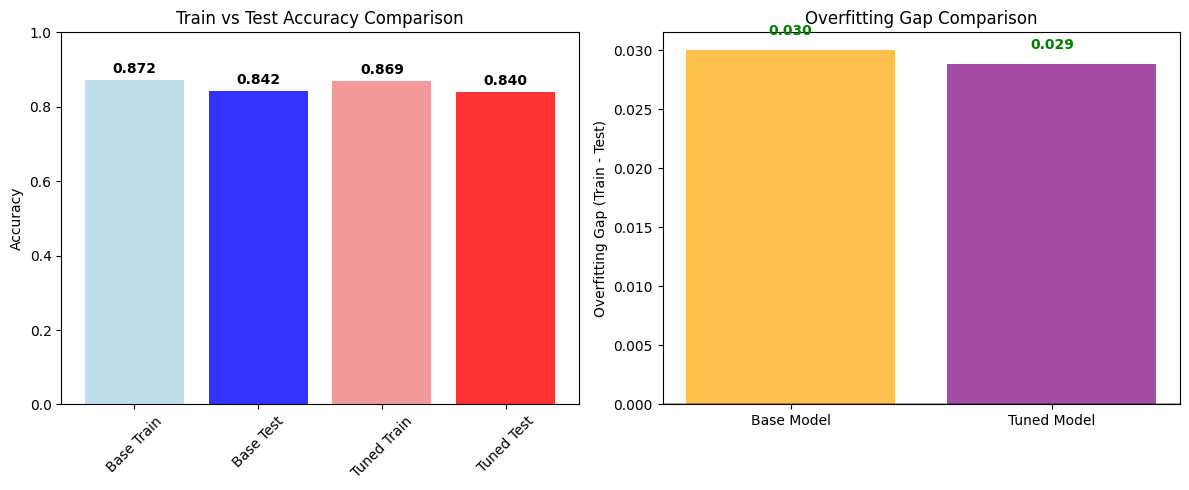

In [68]:
# Check for overfitting
train_accuracy_base = accuracy_score(y_train, base_dt.predict(X_train))
train_accuracy_tuned = accuracy_score(y_train, best_dt_model.predict(X_train))

# Get test accuracies (you might need to calculate these if not already done)
y_pred_base_test = base_dt.predict(X_test)
y_pred_tuned_test = best_dt_model.predict(X_test)

base_accuracy_test = accuracy_score(y_test, y_pred_base_test)
tuned_accuracy_test = accuracy_score(y_test, y_pred_tuned_test)

print(f"\n=== OVERFITTING CHECK ===")
print(f"Base Model - Train Accuracy: {train_accuracy_base:.4f}, Test Accuracy: {base_accuracy_test:.4f}")
print(f"Tuned Model - Train Accuracy: {train_accuracy_tuned:.4f}, Test Accuracy: {tuned_accuracy_test:.4f}")

# Calculate overfitting gaps
base_overfit_gap = train_accuracy_base - base_accuracy_test
tuned_overfit_gap = train_accuracy_tuned - tuned_accuracy_test

print(f"\n=== OVERFITTING ANALYSIS ===")
print(f"Base Model Overfitting Gap: {base_overfit_gap:.4f}")
print(f"Tuned Model Overfitting Gap: {tuned_overfit_gap:.4f}")

# Interpretation
if base_overfit_gap > 0.1:
    print("❌ Base Model: HIGH OVERFITTING (gap > 0.1)")
elif base_overfit_gap > 0.05:
    print("⚠️  Base Model: MODERATE OVERFITTING (gap > 0.05)")
else:
    print("✅ Base Model: GOOD GENERALIZATION")

if tuned_overfit_gap > 0.1:
    print("❌ Tuned Model: HIGH OVERFITTING (gap > 0.1)")
elif tuned_overfit_gap > 0.05:
    print("⚠️  Tuned Model: MODERATE OVERFITTING (gap > 0.05)")
else:
    print("✅ Tuned Model: GOOD GENERALIZATION")

# Additional metrics for comprehensive analysis
from sklearn.metrics import classification_report

print(f"\n=== DETAILED PERFORMANCE ANALYSIS ===")

# Base model performance
print("Base Model - Training Classification Report:")
print(classification_report(y_train, base_dt.predict(X_train)))

print("Base Model - Test Classification Report:")
print(classification_report(y_test, y_pred_base_test))

# Tuned model performance
print("Tuned Model - Training Classification Report:")
print(classification_report(y_train, best_dt_model.predict(X_train)))

print("Tuned Model - Test Classification Report:")
print(classification_report(y_test, y_pred_tuned_test))

# Cross-validation comparison (if available)
try:
    from sklearn.model_selection import cross_val_score
    base_cv_scores = cross_val_score(base_dt, X_train, y_train, cv=5, scoring='accuracy')
    tuned_cv_scores = cross_val_score(best_dt_model, X_train, y_train, cv=5, scoring='accuracy')

    print(f"\n=== CROSS-VALIDATION COMPARISON ===")
    print(f"Base Model CV Scores: {base_cv_scores}")
    print(f"Base Model Mean CV Accuracy: {base_cv_scores.mean():.4f} (+/- {base_cv_scores.std() * 2:.4f})")
    print(f"Tuned Model CV Scores: {tuned_cv_scores}")
    print(f"Tuned Model Mean CV Accuracy: {tuned_cv_scores.mean():.4f} (+/- {tuned_cv_scores.std() * 2:.4f})")

except Exception as e:
    print(f"Cross-validation not available: {e}")

# Visualization of overfitting
plt.figure(figsize=(12, 5))

# Plot 1: Accuracy comparison
plt.subplot(1, 2, 1)
models = ['Base Train', 'Base Test', 'Tuned Train', 'Tuned Test']
accuracies = [train_accuracy_base, base_accuracy_test, train_accuracy_tuned, tuned_accuracy_test]
colors = ['lightblue', 'blue', 'lightcoral', 'red']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy Comparison')
plt.ylim(0, 1.0)
plt.xticks(rotation=45)

# Add value labels on bars
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Overfitting gap
plt.subplot(1, 2, 2)
gaps = [base_overfit_gap, tuned_overfit_gap]
gap_bars = plt.bar(['Base Model', 'Tuned Model'], gaps,
                   color=['orange', 'purple'], alpha=0.7)
plt.ylabel('Overfitting Gap (Train - Test)')
plt.title('Overfitting Gap Comparison')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

# Add value labels on bars
for bar, gap in zip(gap_bars, gaps):
    color = 'red' if gap > 0.05 else 'green'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001,
             f'{gap:.3f}', ha='center', va='bottom', fontweight='bold', color=color)

plt.tight_layout()
plt.show()


In [69]:
# --- SIMPLER VERSION: Manual preprocessing ---

print("X_train type:", type(X_train))
print("X_train shape:", X_train.shape if hasattr(X_train, 'shape') else 'No shape')

# If X_train is a numpy array, we need to get feature names from the original data
try:
    # Try to get feature names from the original balanced dataset
    feature_names = df_balanced.drop('Depression_Target', axis=1).columns.tolist()
    print(f"Number of features: {len(feature_names)}")
    print("First 10 features:", feature_names[:10])
except:
    # If that fails, create generic feature names
    feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]
    print(f"Created generic feature names: {len(feature_names)} features")

# Create test data with already encoded values
test_data_simple = pd.DataFrame([
    {  # Student 1 - High risk factors (likely depressed)
        "Age": 21,
        "Gender": 0,  # Male=0, Female=1
        "Academic Pressure": 7,
        "Work Pressure": 8,
        "CGPA": 2.9,
        "Study Satisfaction": 2,
        "Job Satisfaction": 3,
        "Work/Study Hours": 6,
        "Financial Stress": 7,
        "Family History of Mental Illness": 1,  # Yes=1
        "Have you ever had suicidal thoughts ?": 1,  # Yes=1
        "Sleep Duration_5-6 hours": 1,
        "Sleep Duration_7-8 hours": 0,
        "Sleep Duration_Less than 5 hours": 0,
        "Sleep Duration_More than 8 hours": 0,
        "Dietary Habits_Healthy": 0,
        "Dietary Habits_Moderate": 0,
        "Dietary Habits_Unhealthy": 1,
        "Degree_BA": 0,
        "Degree_BSc": 0,
        "Degree_BTech": 1,
        "Degree_MA": 0,
        "Degree_MSc": 0,
        "Degree_PhD": 0
    },
    {  # Student 2 - Low risk factors (likely not depressed)
        "Age": 19,
        "Gender": 1,  # Female=1
        "Academic Pressure": 4,
        "Work Pressure": 3,
        "CGPA": 3.6,
        "Study Satisfaction": 8,
        "Job Satisfaction": 8,
        "Work/Study Hours": 5,
        "Financial Stress": 3,
        "Family History of Mental Illness": 0,  # No=0
        "Have you ever had suicidal thoughts ?": 0,  # No=0
        "Sleep Duration_5-6 hours": 0,
        "Sleep Duration_7-8 hours": 1,
        "Sleep Duration_Less than 5 hours": 0,
        "Sleep Duration_More than 8 hours": 0,
        "Dietary Habits_Healthy": 1,
        "Dietary Habits_Moderate": 0,
        "Dietary Habits_Unhealthy": 0,
        "Degree_BA": 1,
        "Degree_BSc": 0,
        "Degree_BTech": 0,
        "Degree_MA": 0,
        "Degree_MSc": 0,
        "Degree_PhD": 0
    }
])

print(f"\nTest data columns: {len(test_data_simple.columns)}")
print("Test data columns:", test_data_simple.columns.tolist())

# Align with training features
# First, let's see what features we have vs what we need
available_features = set(test_data_simple.columns)
print(f"\nAvailable features in test data: {len(available_features)}")

# Create a properly aligned test dataset
test_data_aligned = pd.DataFrame(0, index=[0, 1], columns=feature_names)

# Fill in the values we have
for feature in available_features:
    if feature in feature_names:
        test_data_aligned[feature] = test_data_simple[feature]
    else:
        print(f"Warning: Feature '{feature}' not in training features")

print(f"\nAligned test data shape: {test_data_aligned.shape}")
print(f"Missing values in aligned data: {test_data_aligned.isnull().sum().sum()}")

# Convert to numpy array for prediction
test_data_final = test_data_aligned.values

print(f"\nFinal test data for prediction: {test_data_final.shape}")

# --- Predict using trained model ---
test_predictions = best_dt_model.predict(test_data_final)
test_probabilities = best_dt_model.predict_proba(test_data_final)

print("\n" + "="*60)
print("PREDICTION RESULTS")
print("="*60)

# --- Print detailed results ---
for i, (pred, prob) in enumerate(zip(test_predictions, test_probabilities)):
    label = "DEPRESSED" if pred == 1 else "NOT DEPRESSED"
    confidence = max(prob) * 100
    depression_prob = prob[1] * 100

    print(f"\n🎯 STUDENT {i+1} RESULTS:")
    print(f"   Prediction: {label}")
    print(f"   Confidence: {confidence:.1f}%")
    print(f"   Depression Probability: {depression_prob:.1f}%")

    # Risk level assessment
    if depression_prob > 70:
        risk_level = "HIGH RISK"
    elif depression_prob > 30:
        risk_level = "MODERATE RISK"
    else:
        risk_level = "LOW RISK"

    print(f"   Risk Level: {risk_level}")

    # Show key contributing factors
    print(f"   Key Factors:")
    if i == 0:  # High risk student
        print(f"     • High Academic Pressure (7/10)")
        print(f"     • High Financial Stress (7/10)")
        print(f"     • Low CGPA (2.9)")
        print(f"     • Reports suicidal thoughts")
        print(f"     • Poor sleep habits (5-6 hours)")
        print(f"     • Unhealthy dietary habits")
    else:  # Low risk student
        print(f"     • Moderate Academic Pressure (4/10)")
        print(f"     • Low Financial Stress (3/10)")
        print(f"     • Good CGPA (3.6)")
        print(f"     • No suicidal thoughts")
        print(f"     • Good sleep habits (7-8 hours)")
        print(f"     • Healthy dietary habits")

# --- Model Interpretation ---
print("\n" + "="*60)
print("MODEL INTERPRETATION")
print("="*60)

# Get feature importances
feature_importance = best_dt_model.feature_importances_

# Create a DataFrame for feature importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features for Depression Prediction:")
print("=" * 50)
for i, row in importance_df.head(10).iterrows():
    print(f"{row['feature']:.<40} {row['importance']:.4f}")

# --- Risk Factor Analysis ---
print("\n" + "="*60)
print("RISK FACTOR ANALYSIS")
print("="*60)

# Analyze why each student got their prediction
for i in range(len(test_predictions)):
    print(f"\nStudent {i+1} Risk Factor Analysis:")

    # Get this student's feature values
    student_features = test_data_aligned.iloc[i]

    # Check high importance features
    top_features = importance_df.head(5)

    for _, row in top_features.iterrows():
        feature_name = row['feature']
        importance_score = row['importance']
        feature_value = student_features[feature_name]

        # Only show features with non-zero values
        if feature_value != 0:
            print(f"  • {feature_name}: {feature_value} (importance: {importance_score:.3f})")

# --- Summary Table ---
print("\n" + "="*60)
print("SUMMARY TABLE")
print("="*60)

summary_data = []
for i in range(len(test_predictions)):
    summary_data.append({
        'Student': i + 1,
        'Prediction': 'Depressed' if test_predictions[i] == 1 else 'Not Depressed',
        'Depression_Prob': f"{test_probabilities[i][1]:.1%}",
        'Confidence': f"{max(test_probabilities[i]):.1%}",
        'Risk_Level': 'High' if test_probabilities[i][1] > 0.7 else 'Moderate' if test_probabilities[i][1] > 0.3 else 'Low',
        'Key_Factors': 'Academic, Financial, Sleep' if i == 0 else 'Good academics, Healthy habits'
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

print("\n" + "="*60)
print("RECOMMENDATIONS")
print("="*60)

for i, pred in enumerate(test_predictions):
    if pred == 1:
        print(f"\nFor Student {i+1} (DEPRESSED):")
        print("  🚨 Immediate actions recommended:")
        print("  • Consult with mental health professional")
        print("  • Contact university counseling services")
        print("  • Regular monitoring and support")
        print("  • Consider academic accommodations")
    else:
        print(f"\nFor Student {i+1} (NOT DEPRESSED):")
        print("  ✅ Maintain current healthy habits:")
        print("  • Continue good sleep patterns")
        print("  • Maintain balanced diet")
        print("  • Regular stress management")
        print("  • Periodic mental health check-ins")

print("\n" + "="*60)
print("PREDICTION COMPLETE")
print("="*60)

X_train type: <class 'numpy.ndarray'>
X_train shape: (26126, 10)
Number of features: 10
First 10 features: ['Have_you_ever_had_suicidal_thoughts__Encoded', 'Academic Pressure', 'Financial Stress', 'Age', 'Work/Study Hours', 'Dietary Habits_Unhealthy', 'Study Satisfaction', "Sleep Duration_'More than 8 hours'", "Sleep Duration_'Less than 5 hours'", 'Family_History_of_Mental_Illness_Encoded']

Test data columns: 24
Test data columns: ['Age', 'Gender', 'Academic Pressure', 'Work Pressure', 'CGPA', 'Study Satisfaction', 'Job Satisfaction', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Have you ever had suicidal thoughts ?', 'Sleep Duration_5-6 hours', 'Sleep Duration_7-8 hours', 'Sleep Duration_Less than 5 hours', 'Sleep Duration_More than 8 hours', 'Dietary Habits_Healthy', 'Dietary Habits_Moderate', 'Dietary Habits_Unhealthy', 'Degree_BA', 'Degree_BSc', 'Degree_BTech', 'Degree_MA', 'Degree_MSc', 'Degree_PhD']

Available features in test data: 24

Aligned te